# Python codes used for Lecture 3 on Neural Network Training

In [2]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Toy example to illustrate the value of weight decay
We create a synthetic data set in which a discrete target variable y depends on a feature x in a nonlinear manner. We then augment the feature vector with a second covarite that is just random noice and does not contribute to the classification.

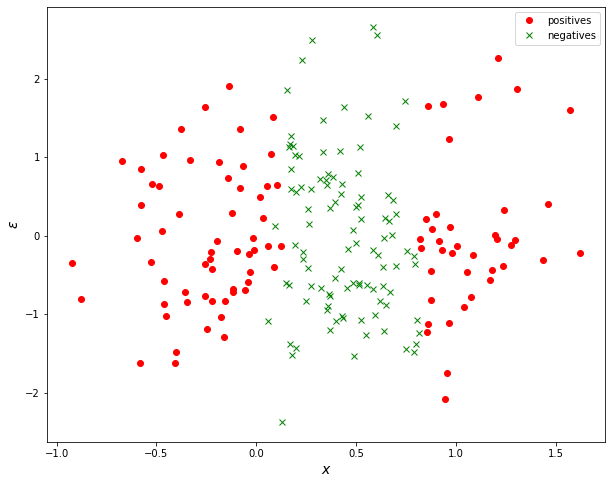

In [14]:
def make_data(N=50):
    ''' Generate synthetic data with sample size N 
    of two variables, x and y, that are related to each
    other in a nonlinear manner. '''
    
    X = 0.5*np.random.normal(size=N)+0.35
    Xt = 0.75*X-0.35
    X = X.reshape((N,1))

    Y = -(8 * Xt**2 + 0.1*Xt + 0.1) + 0.01 * np.random.normal(size=N)
    Y = np.exp(Y) + 0.05 * np.random.normal(size=N)
    Y /= max(np.abs(Y))
    
    # Add another variable which is just random noise
    e = np.random.normal(size=N)
    X =np.insert(X, 0, e, axis=1)
    return X, Y

X, y = make_data(200)
ix_pos = y<0.5
plt.plot(X[ix_pos,1], X[ix_pos,0], 'ro', label='positives')
plt.plot(X[np.invert(ix_pos),1], X[np.invert(ix_pos),0], 'gx', label='negatives')
plt.legend(loc='best')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$\epsilon$', fontsize=14)
plt.show()

## Illustrate the vanishing / exploding gradiant problem
Example taken from https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79
    

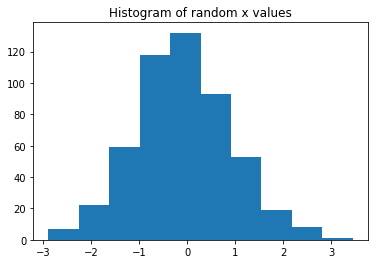

In [13]:
# Generate random input data using the normal distribution
m=512
x = np.random.normal(size=m)
x = x.reshape((m,1))
plt.hist(x)
plt.title("Histogram of random x values")
plt.show()

In [32]:
# Compute forward pass through 100 layers without non-linear activation
# (just matrix multiplication)
for i in range(100):
    W =np.random.normal(size=(m,m))*0.001
    x = np.dot(W,x)
# check moments of the resulting output    
print("Mean of x is {:.2e} with std. deviation of {:.2e}".format(x.mean(), x.std()))

Mean of x is -3.31e-160 with std. deviation of 5.69e-159


## Variance among network weights
We can demonstrate that at a given layer, the matrix product of inputs $x$ and weight matrix $W$ that we initialized from a standard normal distribution will, on average, have a standard deviation very close to the square root of the number of input connections, which in our example is $\sqrt 512$.

In [28]:
m=512
n=100
mean, var = 0., 0.
for i in range(n):
    x = np.random.normal(size=(m,1))
    W = np.random.normal(size=(m,m))
    y = np.dot(W,x)
    mean +=y.mean().item()
    var += y.var().item()

print("Mean over activation levels is {:.4f}".format(mean/n))
print("Variance over activation levels is {:.4f}".format(np.sqrt(var/n)))
print("Root of number of connections is {:.4f}".format(np.sqrt(m)))

Mean over activation levels is 0.0202
Variance over activation levels is 22.3877
Root of number of connections is 22.6274


### Another example of gradient vanishing
Here we show the development of a range of numbers after successive applications of the sigmoid function.

In [30]:
# abandoned
n=10
rep = 10
x = np.linspace(start=-3, stop=3, num=n)

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s
y = np.zeros(shape=(n,rep))

y[0,:]=x    
for i in np.arange(1,rep):
    y[i,:] = sigmoid(y[i-1,])
    
print(x)
print(np.mean(y, axis=0))

[-3.         -2.33333333 -1.66666667 -1.         -0.33333333  0.33333333
  1.          1.66666667  2.33333333  3.        ]
[0.21289463 0.28499136 0.36098874 0.44219719 0.52838551 0.61658307
 0.70240408 0.78312396 0.85871701 0.93054741]


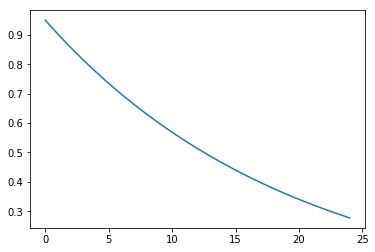

In [46]:
x=0.95
rep = 25
z=np.zeros(rep)
for i in np.arange(rep):
    if i==0:
        z[i]=x
    else:
        z[i]=z[i-1]*x

plt.plot(np.arange(rep),z)
plt.show()

## Illustrate Input Normalization
Consider the RFM score introduced the the lecture as a standard to characterize customer behavior. Image we describe customers in terms of their RFM characteristics using the following measurements:
-  R = recency of last purchase: difference in days from the day of the last purchase to today
-  F = frequency of purchases: average differences in days between two consequtive purchases
-  M = monetary value: aveage purchase amount

Let's focus on just two characteristics, R and F. Naturally, their value ranges will differ. Let's assume customers by every second day on average (R) and assume further that the average inter-purchase time (F) is equal to 4 days. Below, we generate corresponding data using a bi-variate normal distribution, assuming that R and F are independent for simplicity and distributed with variances of 1 and 4, respectively.

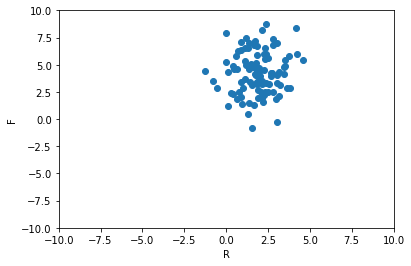

In [15]:
np.random.seed(123)
mu = np.array([2,4])
sig = np.array([[1,0],[0,4]]) 
n=100
samples = np.random.multivariate_normal(mu, sig, n)

# Plot the data
fig = plt.figure()
plt.scatter(samples[:,0],samples[:,1], marker='o')
plt.xlabel("R")
plt.ylabel("F")
plt.ylim(bottom=-10, top=10)
plt.xlim(left=-10, right=10)
plt.show()

The scatter plot highlights the different means and also the larger variance along the F dimension. Let's next verify how standardization makes the R and F values more comparable. To that end, we first substract the mean and plot the resulting data.

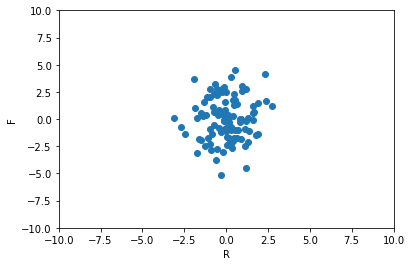

In [16]:
z = (samples - np.mean(samples, axis=0)) 
fig = plt.figure()
plt.scatter(z[:,0],z[:,1], marker='o')
plt.xlabel("R")
plt.ylabel("F")
plt.ylim(bottom=-10, top=10)
plt.xlim(left=-10, right=10)
plt.show()

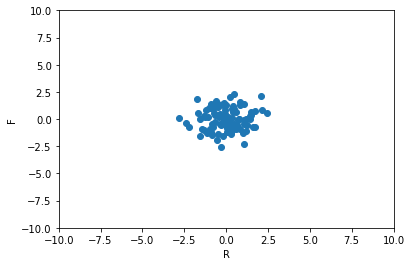

In [17]:

z = z / np.array(np.std(samples, axis=0))

fig = plt.figure()
plt.scatter(z[:,0],z[:,1], marker='o')
plt.xlabel("R")
plt.ylabel("F")
plt.ylim(bottom=-10, top=10)
plt.xlim(left=-10, right=10)
plt.show()

In [24]:
print(z.mean(axis=0))
print(z.std(axis=0))

[-4.15917301e-16  1.52655666e-16]
[1. 1.]
